# Training generative model to generate MNIST digits

The main objective is to design and train a variational autoencoder (VAE) to generate MNIST digits.


# Setting system path
Set working directories and GPU

In [2]:
path='./'
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

### Check whether the path is set correctly

In [3]:
!ls $path

data  main.ipynb  models  train  utils


## Import package and set configs

In [30]:
import torch
from torch import nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from math import sqrt

from models.encoder import Encoder
from models.decoder import Decoder
from data.dataloader import MNISTdataloader
from utils.utils import *
from utils.losses import *
from train.train import train_VAE

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


config namespace for storing hyperparameters

In [6]:
from types import SimpleNamespace

# The config is used to store various hyperparameters

config = SimpleNamespace(
    seed = 1,
    batch_size = 256,
    test_batch_size = 100,
    lr = 2e-4,
    epoch = 10,
    latent_dim = 2,
    input_shape = (1,16,16),
    hidden_dims = [256,128,64,32],
    expand_dim = 2,
    beta = 2,
)

In [8]:
# Check device is 'cuda' if GPU is available
device = 'cpu' if not torch.cuda.is_available() else 'cuda'
device

'cuda'

In [9]:
# set randomness
set_randomness(config.seed)

# Beta Variational AutoEncoder (beta-VAE)
This section is based on the following papers:
- [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114)
- [beta-VAE: Learning Basic Visual Concepts with a Constrained Variational Framework](https://openreview.net/pdf?id=Sy2fzU9gl)

In this section, beta Variational AutoEncoder (beta-VAE), and training is implemented. The VAE is a generative model that can be trained in an unsupervised manner. The beta-VAE is a variant of the VAE that can learn disentangled representations. They introduce an adjustable hyperparameter `beta` that balances latent channel capacity and independence constraints with reconstruction accuracy.

The only difference between VAE and beta-VAE is the `loss function`. The beta-VAE and VAE have no difference in terms of the architecture. Therefore, we `take the same approach as the VAE` except for constructing the loss function.

The VAE is composed of two parts: an encoder and a decoder. The encoder encodes the input data into a latent vector, and the decoder decodes the latent vector into the output data. The encoder and decoder are trained simultaneously.

The encoder in the AE encodes the input data into a latent vector, and it is directly passed to the decoder. The decoder in the AE decodes the latent vector into the output data. The encoder and decoder are trained simultaneously.

The difference between AE and VAE is that the AE does not consider the distribution of the latent vector. The AE is trained to minimize the reconstruction error between the input data and the output data. On the other hand, the VAE is trained to minimize the reconstruction error and the KL divergence between the latent vector and the prior distribution. (The identical reconstruction error will be used) For later comparison between AutoEncoder and Variational AutoEncoder, you are asked to implement shared model architecture for both AutoEncoder and Variational AutoEncoder.

Here is how the input data flows and the output are generated for the AutoEncoder and Variational AutoEncoder (self.xxx indicates the layer or model in the `Encoder` class):
```
    AutoEncoder
        - input -> self.model -> self.fc_mean -> final output (will be passed to the decoder)
    
    Variational AutoEncoder
        - input -> self.model -> intermediate output
        - intermediate output -> self.fc_mean    -> output (one latent vector, mean)
        - intermediate output -> self.fc_logvar  -> output (one latent vector, logvar)
        - two latent vectors (mean and logvar)   -> self.reparameterize -> final output (will be passed to the decoder)
```

Here is the config for the AutoEncoder and Variational AutoEncoder:
```
    AutoEncoder
        - beta: 0
        - loss function: reconstruction loss
    
    Variational AutoEncoder
        - beta: 1
        - loss function: VAE loss (reconstruction loss + KL divergence)
```
The only difference between AE and VAE is the `loss function` and `reparameterization`.


## Encoder
The `Encoder` class is composed of four convolutional layers and two fully-connected layers. The input of the `Encoder` class is an image tensor, and the output is a latent vector.

The Encoder could work as Encoder in AutoEncoder and Variational AutoEncoder. The operation depends on the argument `model_name` passed into the `Encoder` class.
- If `model_name` is `AE`, the Encoder works as Encoder in AutoEncoder.
- If `model_name` is `VAE`, the Encoder works as Encoder in Variational AutoEncoder.
    - `beta-VAE` is also a variant of the VAE. Therefore, you can use the `VAE` model for `beta-VAE`.

For VAE, the `reparameterize` function is used to reparameterize the latent vector. The latent vector is sampled from the Gaussian distribution with `mean` and `logvar`. 

The input of the `Encoder` class is an image tensor, and the output is a latent vector. The `input_dim` is the dimension of the input image, and the `hidden_dim` is the dimension of the hidden layer. The `latent_dim` is the dimension of the latent vector.

In Autoencoder, the `fc_mean` layer works as last layer and outputs the latent vector (`fc_logvar` is defined, but not used). Then, the latent vector directly passes to the `Decoder`.

In Variational AutoEncoder, the outputs of `fc_mean` and `fc_logvar` layers are used to reparameterize the latent vector. Then, the reparameterized latent vector  passes to the `Decoder`.

### 1.1 AutoEncoder model

In [10]:
encoder = Encoder(hidden_dims = config.hidden_dims,
                  latent_dim=config.latent_dim,model_name='AE').to(device) # or model_name='VAE'
print(encoder)

Encoder(
  (model): Sequential(
    (0): Conv2d(1, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
  )
  (fc_mean): Linear(in_features=32, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=32, out_features=2, bias=True)
)


### 1.2 forward for AutoEncoder
The forward path of the `Encoder` class is as follows:
- Input image tensor is passed through the convolutional layers
- The output of the convolutional layers is passed through the one fully-connected layers (`fc_mean`).
- The output of the fully-connected layers (`self.fc_mean`) will be returned
    - Need to flatten the output of the convolutional layers before passing through the fully-connected layers


In [11]:
encoder = Encoder(hidden_dims = config.hidden_dims,
                  latent_dim=config.latent_dim,model_name='AE').to(device)
image = cv2.imread("./utils/test_file/GAN_0050.png",cv2.IMREAD_GRAYSCALE)[2:18,2:18]
image = image/255
image = torch.Tensor(image).unsqueeze(0).unsqueeze(0).repeat(2,1,1,1).to(device)
out = encoder(image)
print(out.shape)

torch.Size([2, 2])


### 1.3 Reparameterization trick for VAE
The implementation of `Encoder` for `AE` is done. It is time to construct `Encoder` for `VAE`.

The reparameterization trick is as follows:
- Sample a random vector $\epsilon$ (in our code, `eps`) from the standard normal distribution
- Compute the latent vector (in our code, `rp`) by $\mu + \sigma \odot \epsilon$, where $\mu$ and $\sigma$ are the mean and standard deviation of the latent distribution, respectively. $\odot$ is the element-wise multiplication.
- Return the latent vector `rp`


In [12]:
encoder = Encoder(hidden_dims = config.hidden_dims, latent_dim=config.latent_dim,
                  model_name='VAE').to(device)
eps = torch.Tensor([0.1,-0.01]).to(device)
mu = torch.Tensor([-0.1,0.01]).to(device)
logvar = torch.Tensor([0.1,0.1]).to(device)
out = encoder.reparametrize(mu, logvar,eps)
print(out)

tensor([ 0.0051, -0.0005], device='cuda:0')


### 1.4 forward function for VAE
The forward path of the `Encoder` class is as follows:
- Input image tensor is passed through the convolutional layers
- The output of the convolutional layers is passed through the two fully-connected layers (`fc_mean`, `fc_logvar`), respectively.
    - Need to flatten the output of the convolutional layers before passing through the fully-connected layers
- The ***two output*** (`mu`,`logvar`) of the fully-connected layers is to through the `reparameterize` function


In [15]:
image = cv2.imread("./utils/test_file/GAN_0050.png",cv2.IMREAD_GRAYSCALE)[2:18,2:18]
image = image/255
image = torch.Tensor(image).unsqueeze(0).unsqueeze(0).repeat(2,1,1,1).to(device)
mean, logvar, rp = encoder(image)
print(mean.shape, logvar.shape, rp.shape)

torch.Size([2, 2]) torch.Size([2, 2]) torch.Size([2, 2])


## 2. Decoder
The `Decoder` class is composed of four convolutional layers. The `self.decoder` architecture is reverse version of `Encoder` except `fc_mean` and `fc_logvar` layer. The input of the `Encoder` class is an image tensor, and the output is a latent vector.


### 2.1. \_\_init\_\_
The `Decoder` class is composed of four convolutional layers. The architecture is reverse version of `Encoder`. The input of the `Encoder` class is an image tensor, and the output is a latent vector. The `input_dim` is the dimension of the input image, and the `hidden_dim` is the dimension of the hidden layer. The `latent_dim` is the dimension of the latent vector.

`self.input_layer` works as the first layer of the `Decoder`. The output of the `self.input_layer` is reshaped to `(B,self.hidden_dims[-1],self.expand_dim,self.expand_dim)`. Then, the reshaped output is passed through the `self.decoder` layers. The output of the `self.decoder` layers is passed through the `self.last_layer` layer. The output of the `self.last_layer` layer is the output of the `Decoder`.


In [16]:
decoder = Decoder(hidden_dims = config.hidden_dims, latent_dim=config.latent_dim,expand_dim=config.expand_dim).to(device)
print(decoder)

Decoder(
  (input_layer): Linear(in_features=2, out_features=128, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): ConvTranspose2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): ConvTranspose2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
  )
  (last_layer): Sequential(
    (0): ConvTranspose2d(256, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Sigmoid()
  )
)


### 2.2 forward
The forward function of the `Decoder` class is as follows:
- Input latent vector is passed through the `self.input_layer`
- The output of the fully-connected layer is reshaped to `(B,self.hidden_dims[-1],self.expand_dim,self.expand_dim)`
- The output of the fully-connected layer is passed through `self.decoder`
- The output of the convolutional layers is passed through `self.last_layer`

In [17]:
decoder = Decoder(hidden_dims = config.hidden_dims, latent_dim=config.latent_dim,expand_dim=config.expand_dim).to(device)
input = torch.randn(2, 1, 16, 16).to(device)
# AE case
encoder = Encoder(hidden_dims = config.hidden_dims, latent_dim=config.latent_dim,
                  model_name='AE').to(device)
latent = encoder(input)
out = decoder(latent)
print("For AE, decoder output :",out.shape)
# VAE case
encoder = Encoder(hidden_dims = config.hidden_dims, latent_dim=config.latent_dim,
                  model_name='VAE').to(device)
mean, logvar, rp = encoder(input)
out = decoder(rp)
print("For VAE, decoder output :",out.shape)

For AE, decoder output : torch.Size([2, 1, 16, 16])
For VAE, decoder output : torch.Size([2, 1, 16, 16])


## 3. Loss function (Evidence Lower Bound)
The `Encoder` and `Decoder` follow the following distributions:
- The output of the 'Encoder' class follows the `Gaussian distribution` for the `VAE` family and does not follow any distribution for the `AE`.
- The output of the 'Decoder' class follows the `Bernoulli distribution`.


The loss function of the AE is as follows:
- AE loss
    - $L_{AE} = L_{rec}$

Where $L_{rec}$ is reconstruction loss (same loss for VAE and beta-VAE).

And, the loss function of the beta-VAE is as follows:
- VAE loss
    - $L_{VAE} = L_{rec} + \beta L_{KL}$

    
Where $L_{rec}$ is reconstruction loss and $L_{KL}$ is KL divergence loss. $\beta$ is the hyperparameter that balances the latent channel capacity and independence constraints with reconstruction accuracy.

When $\beta$ is 1, the loss function is the same as the VAE.

In [19]:

config.latent_dim = 2
image1 = cv2.imread("./utils/test_file/GAN_0050.png",cv2.IMREAD_GRAYSCALE)[2:18,2:18] / 255
image1 = torch.Tensor(image1).unsqueeze(0).unsqueeze(0).repeat(2,1,1,1).to(device)
image2 = cv2.imread("./utils/test_file/GAN_0100.png",cv2.IMREAD_GRAYSCALE)[2:18,2:18] / 255
image2 = torch.Tensor(image2).unsqueeze(0).unsqueeze(0).repeat(2,1,1,1).to(device)

encoder = Encoder(hidden_dims = config.hidden_dims, latent_dim=config.latent_dim).to(device)
decoder = Decoder(hidden_dims = config.hidden_dims, latent_dim=config.latent_dim,expand_dim=config.expand_dim).to(device)
# If you have trouble loading the model, please check the model architecture
encoder.load_state_dict(torch.load('./utils/test_file/init_encoder.pth',map_location=device))
decoder.load_state_dict(torch.load('./utils/test_file/init_decoder.pth',map_location=device))


eps = torch.Tensor([0.1,-0.01]).to(device)
mean1, logvar1, rp1 = encoder(image1,eps)

recon_image1 = decoder(rp1)
result = loss_function(recon_image1,image1,mean1,logvar1,return_info=True)

reference_result = torch.load('./utils/test_file/test_results_VAE_loss.pth',map_location=device)

print("======== Implemented results ========")
for key, value in result.items():
    print("-",key, value.item())
print("======== Reference results ========")
for key, value in reference_result.items():
    print("-",key, value.item())

# assert abs(result['loss'].item() - reference_result['loss'].item()) < 1e-2, f"Wrong loss function implementation {result['loss'].item()}"
assert abs(result['recon_loss'].item() - reference_result['recon_loss'].item()) < 1e-2, f"Wrong reconstruction loss function implementation {result['recon_loss'].item()}"
assert abs(result['kld_loss'].item() - reference_result['kld_loss'].item()) < 1e-2, f"Wrong KLD loss function implementation {result['kld_loss'].item()}"

======== Implemented results ========
- loss 191.02725219726562
- recon_loss 191.0111083984375
- kld_loss 0.016148030757904053
======== Reference results ========
- loss 191.0272216796875
- recon_loss 191.01107788085938
- kld_loss 0.016147971153259277


In [20]:
mu = torch.Tensor([[-0.1,0.01],[0.05,-0.01]]).to(device)
logvar = torch.Tensor([[0.1,0.1],[0.05,0.1]]).to(device)
for beta in [1,5,10]:
    loss = loss_function(image1,image1,mu,logvar,beta=beta)
    print(f"beta {beta}\t:",loss.item())

beta 1	: 48.04874801635742
beta 5	: 48.07823181152344
beta 10	: 48.115089416503906


## 4. Training beta-VAE
The training flow of the beta-VAE is as follows (Same as the VAE):
- Input image tensor is passed through the `Encoder` class
- The output of the `Encoder` class is passed through the `Decoder` class
- The outputs of the `Decoder` class and `Encoder` class are compared with the input image tensor using the `loss function`.
- The loss is backpropagated to update the parameters of the `Encoder` and `Decoder` classes
- Update the parameters of the `Encoder` and `Decoder` classes


### 4.1. Custom dataloader and preprocessing for training procedure
The `dataloader` class is used to load the MNIST dataset.

The preprocessing for the input consists of the following components:
1. Resize the image
    - The expected image shape for the generator and discriminator  is (1,16,16), but the original image shape of MNIST is (1,28,28). To align it, the input image should be `resize` into (1,16,16).
2. Change the data type
    - change variable type from numpy array `into torch.Tensor` to train neural network since the network expects torch.Tensor type input.


In [25]:
loader_for_test = MNISTdataloader(train=False, download=True, batch_size=config.batch_size)
print(loader_for_test.transform)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:40<00:00, 244332.04it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 113745.32it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:17<00:00, 93742.16it/s] 


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 5474289.88it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Compose(
    Resize(size=(16, 16), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [26]:

loader_for_test = MNISTdataloader(train=False, batch_size=10)
for img, label in loader_for_test:
    print(f"The shape of image from the dataloader : {img.shape}")
    print(f"The type of image from the dataloader : {type(img)}")
    print(f"The min / max of image from the dataloader : {img.min()} / {img.max()}")
    print(f"The shape of label from the dataloader : {label.shape}")
    break

The shape of image from the dataloader : torch.Size([10, 1, 16, 16])
The type of image from the dataloader : <class 'torch.Tensor'>
The min / max of image from the dataloader : 0.0 / 0.9921568632125854
The shape of label from the dataloader : torch.Size([10])


In [27]:
save_path = "./results/plots/"

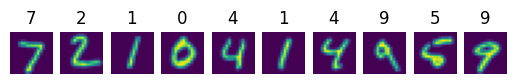

In [28]:

fig = plt.figure()
img = img.numpy().transpose(0,2,3,1)
label = label.numpy().squeeze()
for i in range(10):
  train_x = img[i]
  train_y = label[i]

  ax = fig.add_subplot(1, 10, i+1)
  ax.imshow(train_x)
  ax.set_title(str(train_y.item()))
  ax.axis("off")

plt.savefig(save_path+"mnist_img.png")
plt.show()


In [35]:
from copy import deepcopy
# for AE
test_config = deepcopy(config)
test_config.batch_size =2
test_config.latent_dim = 2
eps = torch.load('./utils/test_file/test_eps.pth',map_location=device)
images = torch.load('./utils/test_file/test_images_MNIST.pth',map_location=device)
labels = torch.load('./utils/test_file/test_labels_MNIST.pth',map_location=device)

encoder = Encoder(hidden_dims = test_config.hidden_dims, latent_dim=test_config.latent_dim,model_name='AE').to(device)
decoder = Decoder(hidden_dims = test_config.hidden_dims, latent_dim=test_config.latent_dim,expand_dim=test_config.expand_dim).to(device)
encoder.load_state_dict(torch.load('./utils/test_file/init_encoder.pth',map_location=device),strict=False)
decoder.load_state_dict(torch.load('./utils/test_file/init_decoder.pth',map_location=device),strict=False)

trainer = train_VAE(train_loader = None, test_loader = None,
                       encoder=encoder, decoder=decoder,
                       device=device, config=test_config, save_img=False,
                       model_name='AE')
result = trainer.one_iter_train(images,labels,eps)
reference_result = torch.load('./utils/test_file/test_results_AE.pth',map_location=device)
print("Implemented result: \n",result['recon_loss'])
print("Reference result: \n",reference_result['recon_loss'])

assert abs(result['recon_loss'] - reference_result['recon_loss']) < 1e-2, "Reconstruction loss is wrong"


Implemented result: 
 196.1309814453125
Reference result: 
 196.1310272216797


In [36]:

# training VAE
test_config = deepcopy(config)
test_config.batch_size =2
test_config.latent_dim = 2
eps = torch.load('./utils/test_file/test_eps.pth',map_location=device)
images = torch.load('./utils/test_file/test_images_MNIST.pth',map_location=device)
labels = torch.load('./utils/test_file/test_labels_MNIST.pth',map_location=device)

encoder = Encoder(hidden_dims = test_config.hidden_dims, latent_dim=test_config.latent_dim,model_name='VAE').to(device)
decoder = Decoder(hidden_dims = test_config.hidden_dims, latent_dim=test_config.latent_dim,expand_dim=test_config.expand_dim).to(device)
encoder.load_state_dict(torch.load('./utils/test_file/init_encoder.pth',map_location=device))
decoder.load_state_dict(torch.load('./utils/test_file/init_decoder.pth',map_location=device))

trainer = train_VAE(train_loader = None, test_loader = None,
                       encoder=encoder, decoder=decoder,
                       device=device, config=test_config, save_img=False)
result = trainer.one_iter_train(images,labels,eps)

reference_result = torch.load('./utils/test_file/test_results_VAE.pth',map_location=device)
print("Implemented result: \n",result)
print("Reference result: \n",reference_result)

assert abs(result['recon_loss'] - reference_result['recon_loss']) < 1e-2, "Reconstruction loss is wrong"
assert abs(result['kld_loss'] - reference_result['kld_loss']) < 1e-2, "KL divergence loss is wrong"

Implemented result: 
 {'recon_loss': 195.93617248535156, 'kld_loss': 0.01583707332611084}
Reference result: 
 {'recon_loss': 195.93630981445312, 'kld_loss': 0.015837177634239197}


### 4.3 Training AE, VAE, and beta-VAE

Epoch [1/20], Step [235/234], Total loss : 66.221207 Recon Loss: 66.221207, KLD Loss: 0.000000: 100%|██████████| 234/234 [00:05<00:00, 45.93it/s]


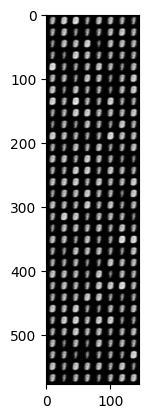

Epoch [2/20], Step [235/234], Total loss : 61.985390 Recon Loss: 61.985390, KLD Loss: 0.000000: 100%|██████████| 234/234 [00:04<00:00, 47.25it/s]


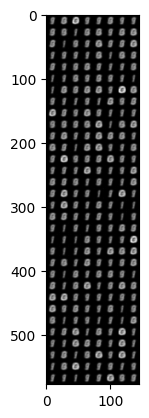

Epoch [3/20], Step [235/234], Total loss : 61.062702 Recon Loss: 61.062702, KLD Loss: 0.000000: 100%|██████████| 234/234 [00:05<00:00, 46.47it/s]


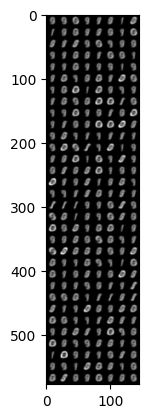

Epoch [4/20], Step [235/234], Total loss : 57.477371 Recon Loss: 57.477371, KLD Loss: 0.000000: 100%|██████████| 234/234 [00:02<00:00, 78.79it/s] 


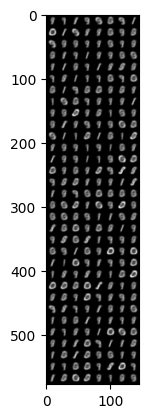

Epoch [5/20], Step [235/234], Total loss : 57.859135 Recon Loss: 57.859135, KLD Loss: 0.000000: 100%|██████████| 234/234 [00:04<00:00, 47.77it/s]


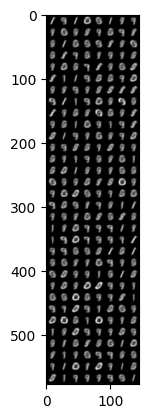

Epoch [6/20], Step [235/234], Total loss : 57.097034 Recon Loss: 57.097034, KLD Loss: 0.000000: 100%|██████████| 234/234 [00:04<00:00, 49.29it/s]


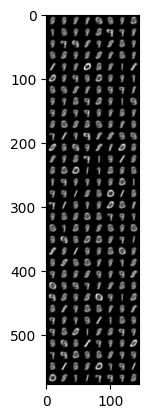

Epoch [7/20], Step [235/234], Total loss : 55.575474 Recon Loss: 55.575474, KLD Loss: 0.000000: 100%|██████████| 234/234 [00:04<00:00, 47.81it/s]


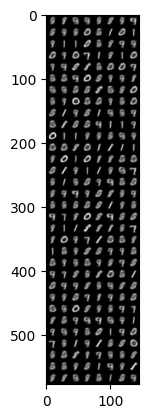

Epoch [8/20], Step [235/234], Total loss : 56.875462 Recon Loss: 56.875462, KLD Loss: 0.000000: 100%|██████████| 234/234 [00:04<00:00, 49.28it/s]


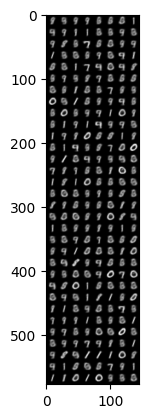

Epoch [9/20], Step [235/234], Total loss : 55.682602 Recon Loss: 55.682602, KLD Loss: 0.000000: 100%|██████████| 234/234 [00:04<00:00, 50.02it/s]


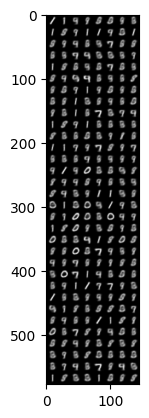

Epoch [10/20], Step [235/234], Total loss : 56.901939 Recon Loss: 56.901939, KLD Loss: 0.000000: 100%|██████████| 234/234 [00:03<00:00, 70.61it/s]


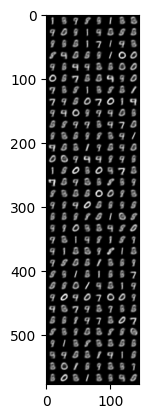

Epoch [11/20], Step [235/234], Total loss : 57.641785 Recon Loss: 57.641785, KLD Loss: 0.000000: 100%|██████████| 234/234 [00:04<00:00, 49.26it/s]


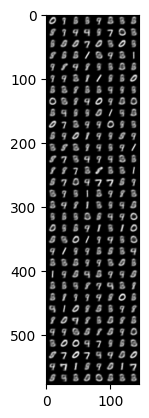

Epoch [12/20], Step [235/234], Total loss : 55.831161 Recon Loss: 55.831161, KLD Loss: 0.000000: 100%|██████████| 234/234 [00:05<00:00, 46.19it/s]


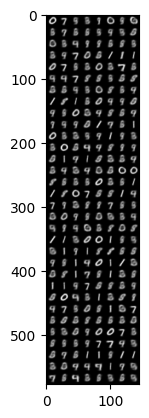

Epoch [13/20], Step [235/234], Total loss : 54.684181 Recon Loss: 54.684181, KLD Loss: 0.000000: 100%|██████████| 234/234 [00:04<00:00, 47.73it/s]


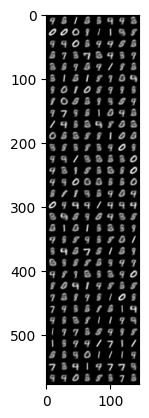

Epoch [14/20], Step [235/234], Total loss : 56.277401 Recon Loss: 56.277401, KLD Loss: 0.000000: 100%|██████████| 234/234 [00:04<00:00, 47.21it/s]


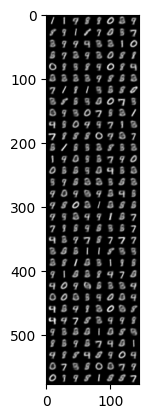

Epoch [15/20], Step [235/234], Total loss : 53.788460 Recon Loss: 53.788460, KLD Loss: 0.000000: 100%|██████████| 234/234 [00:04<00:00, 47.49it/s]


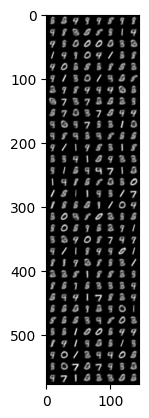

Epoch [16/20], Step [235/234], Total loss : 54.739101 Recon Loss: 54.739101, KLD Loss: 0.000000: 100%|██████████| 234/234 [00:04<00:00, 49.17it/s]


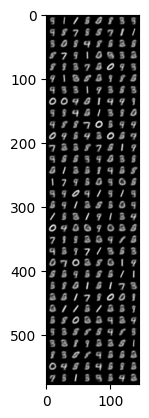

Epoch [17/20], Step [235/234], Total loss : 55.517342 Recon Loss: 55.517342, KLD Loss: 0.000000: 100%|██████████| 234/234 [00:03<00:00, 70.14it/s] 


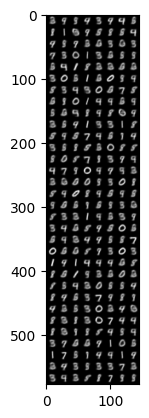

Epoch [18/20], Step [235/234], Total loss : 53.095039 Recon Loss: 53.095039, KLD Loss: 0.000000: 100%|██████████| 234/234 [00:04<00:00, 48.77it/s]


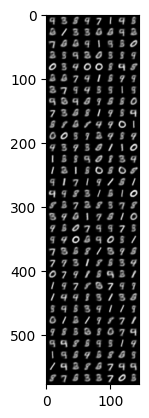

Epoch [19/20], Step [235/234], Total loss : 54.725033 Recon Loss: 54.725033, KLD Loss: 0.000000: 100%|██████████| 234/234 [00:04<00:00, 47.12it/s]


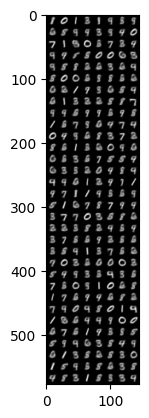

Epoch [20/20], Step [235/234], Total loss : 54.923119 Recon Loss: 54.923119, KLD Loss: 0.000000: 100%|██████████| 234/234 [00:04<00:00, 47.05it/s]


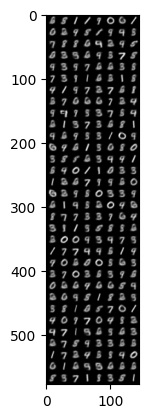

Saving gif file...


In [38]:

config.epoch = 20
train_loader = MNISTdataloader(train=True, batch_size=config.batch_size)
test_loader = MNISTdataloader(train=False, batch_size=config.batch_size)
encoder = Encoder(hidden_dims = config.hidden_dims, latent_dim=config.latent_dim,
                  model_name='AE').to(device)
decoder = Decoder(hidden_dims = config.hidden_dims, latent_dim=config.latent_dim,expand_dim=config.expand_dim).to(device)
encoder.apply(initialize_weights)
decoder.apply(initialize_weights)
trainer = train_VAE(train_loader, test_loader,encoder, decoder, device, config, \
                       save_img=True,model_name='AE',beta=config.beta,img_show=True)
results_AE = trainer.train()

In [33]:
trained_encoder_AE = results_AE['encoder']
trained_decoder_AE = results_AE['decoder']
recon_loss_AE = results_AE['Recon_loss_history']

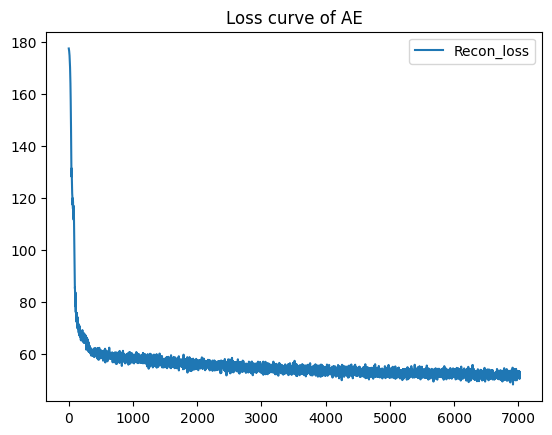

In [57]:
plt.title("Loss curve of AE")
plt.plot(recon_loss_AE, label='Recon_loss')
plt.legend()
plt.savefig(save_path+"AE_loss.png")
plt.show()

### Let's train VAE!
Let's train VAE (with beta 1) for 20 epochs to get reasonable result. (It takes around 10 minutes to train 20 epoch.)

Epoch [1/30], Step [235/234], Total loss : 70.857148 Recon Loss: 70.207809, KLD Loss: 0.649339: 100%|██████████| 234/234 [00:05<00:00, 46.02it/s]


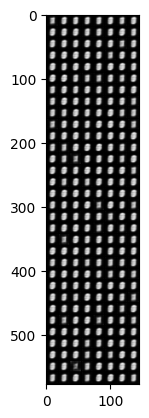

Epoch [2/30], Step [235/234], Total loss : 65.597551 Recon Loss: 64.271042, KLD Loss: 1.326509: 100%|██████████| 234/234 [00:04<00:00, 48.46it/s]


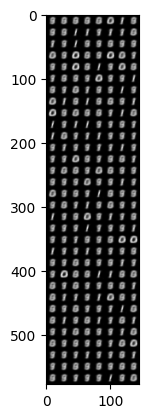

Epoch [3/30], Step [235/234], Total loss : 65.571661 Recon Loss: 64.138725, KLD Loss: 1.432936: 100%|██████████| 234/234 [00:04<00:00, 49.33it/s]


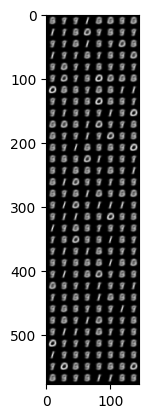

Epoch [4/30], Step [235/234], Total loss : 62.882345 Recon Loss: 61.155029, KLD Loss: 1.727316: 100%|██████████| 234/234 [00:04<00:00, 49.36it/s]


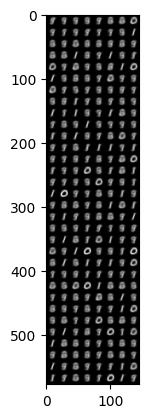

Epoch [5/30], Step [235/234], Total loss : 61.171957 Recon Loss: 58.063385, KLD Loss: 3.108572: 100%|██████████| 234/234 [00:04<00:00, 49.14it/s]


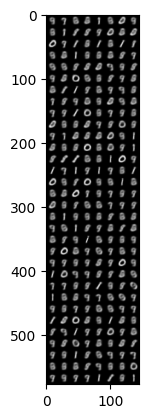

Epoch [6/30], Step [235/234], Total loss : 60.539979 Recon Loss: 57.483940, KLD Loss: 3.056039: 100%|██████████| 234/234 [00:04<00:00, 50.75it/s]


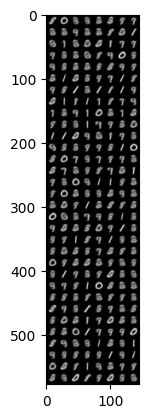

Epoch [7/30], Step [235/234], Total loss : 60.850006 Recon Loss: 57.546791, KLD Loss: 3.303215: 100%|██████████| 234/234 [00:04<00:00, 50.91it/s]


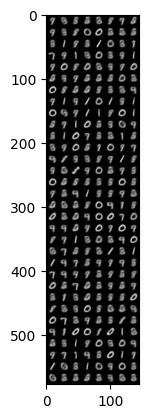

Epoch [8/30], Step [235/234], Total loss : 58.634941 Recon Loss: 55.346497, KLD Loss: 3.288445: 100%|██████████| 234/234 [00:04<00:00, 51.07it/s]


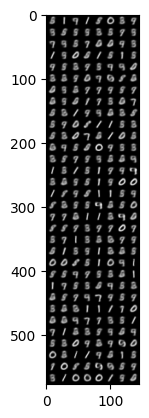

Epoch [9/30], Step [235/234], Total loss : 61.085837 Recon Loss: 57.683571, KLD Loss: 3.402266: 100%|██████████| 234/234 [00:04<00:00, 50.68it/s]


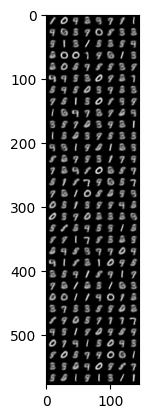

Epoch [10/30], Step [235/234], Total loss : 59.798378 Recon Loss: 56.166367, KLD Loss: 3.632011: 100%|██████████| 234/234 [00:04<00:00, 51.32it/s]


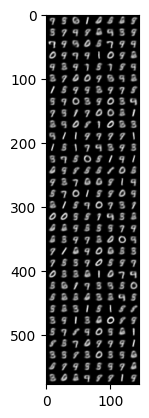

Epoch [11/30], Step [235/234], Total loss : 61.226654 Recon Loss: 57.767456, KLD Loss: 3.459198: 100%|██████████| 234/234 [00:04<00:00, 50.93it/s]


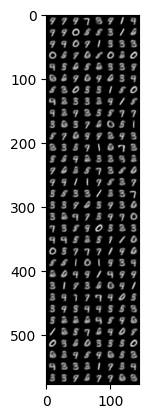

Epoch [12/30], Step [235/234], Total loss : 60.030233 Recon Loss: 56.463810, KLD Loss: 3.566423: 100%|██████████| 234/234 [00:04<00:00, 51.20it/s]


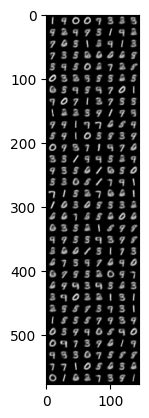

Epoch [13/30], Step [235/234], Total loss : 58.470731 Recon Loss: 54.836304, KLD Loss: 3.634427: 100%|██████████| 234/234 [00:04<00:00, 50.47it/s]


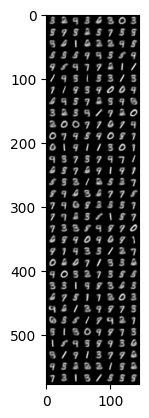

Epoch [14/30], Step [235/234], Total loss : 58.666512 Recon Loss: 54.828613, KLD Loss: 3.837899: 100%|██████████| 234/234 [00:04<00:00, 50.99it/s]


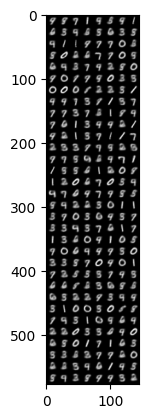

Epoch [15/30], Step [235/234], Total loss : 57.631293 Recon Loss: 53.941551, KLD Loss: 3.689742: 100%|██████████| 234/234 [00:04<00:00, 50.70it/s]


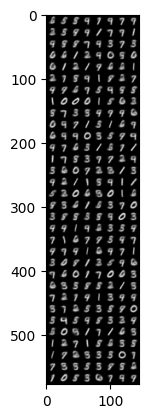

Epoch [16/30], Step [235/234], Total loss : 58.560076 Recon Loss: 54.640373, KLD Loss: 3.919703: 100%|██████████| 234/234 [00:04<00:00, 50.47it/s]


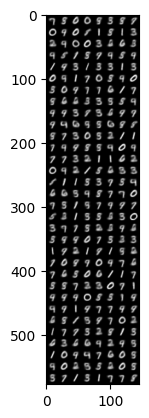

Epoch [17/30], Step [235/234], Total loss : 59.316734 Recon Loss: 55.452705, KLD Loss: 3.864029: 100%|██████████| 234/234 [00:04<00:00, 50.69it/s]


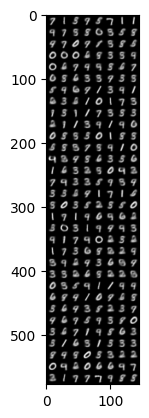

Epoch [18/30], Step [235/234], Total loss : 58.015105 Recon Loss: 54.035961, KLD Loss: 3.979144: 100%|██████████| 234/234 [00:04<00:00, 49.58it/s]


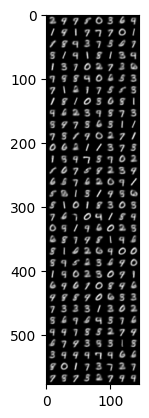

Epoch [19/30], Step [235/234], Total loss : 56.315223 Recon Loss: 52.372520, KLD Loss: 3.942702: 100%|██████████| 234/234 [00:04<00:00, 49.38it/s]


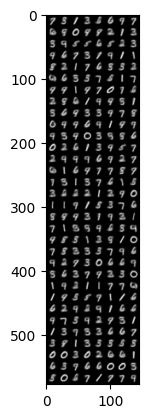

Epoch [20/30], Step [235/234], Total loss : 58.290339 Recon Loss: 54.197933, KLD Loss: 4.092406: 100%|██████████| 234/234 [00:04<00:00, 48.92it/s]


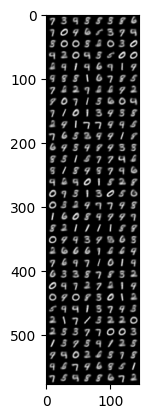

Epoch [21/30], Step [235/234], Total loss : 57.120850 Recon Loss: 53.088848, KLD Loss: 4.032001: 100%|██████████| 234/234 [00:04<00:00, 48.00it/s]


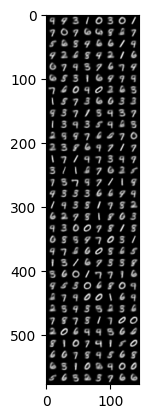

Epoch [22/30], Step [235/234], Total loss : 57.628513 Recon Loss: 53.496353, KLD Loss: 4.132160: 100%|██████████| 234/234 [00:04<00:00, 48.49it/s]


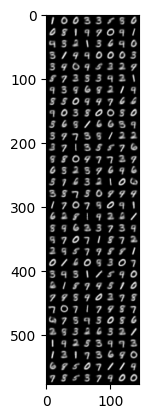

Epoch [23/30], Step [235/234], Total loss : 58.962309 Recon Loss: 54.749233, KLD Loss: 4.213076: 100%|██████████| 234/234 [00:04<00:00, 48.57it/s]


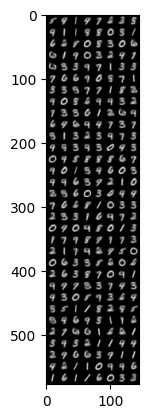

Epoch [24/30], Step [235/234], Total loss : 56.589107 Recon Loss: 52.539410, KLD Loss: 4.049697: 100%|██████████| 234/234 [00:04<00:00, 48.28it/s]


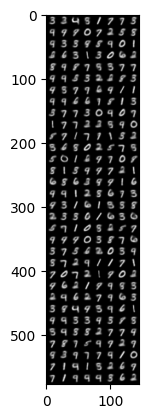

Epoch [25/30], Step [235/234], Total loss : 57.626215 Recon Loss: 53.606354, KLD Loss: 4.019862: 100%|██████████| 234/234 [00:04<00:00, 47.42it/s]


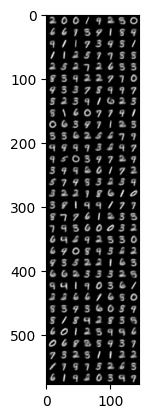

Epoch [26/30], Step [235/234], Total loss : 57.497106 Recon Loss: 53.487698, KLD Loss: 4.009408: 100%|██████████| 234/234 [00:04<00:00, 48.39it/s]


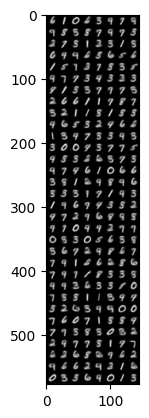

Epoch [27/30], Step [235/234], Total loss : 56.478311 Recon Loss: 52.363533, KLD Loss: 4.114778: 100%|██████████| 234/234 [00:04<00:00, 48.28it/s]


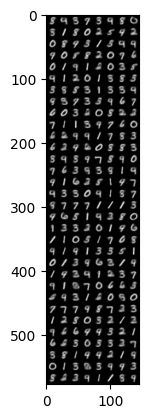

Epoch [28/30], Step [235/234], Total loss : 58.386196 Recon Loss: 54.118706, KLD Loss: 4.267490: 100%|██████████| 234/234 [00:04<00:00, 48.16it/s]


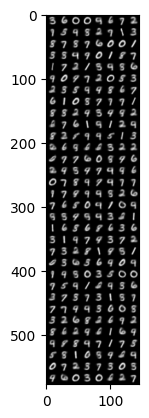

Epoch [29/30], Step [235/234], Total loss : 57.470476 Recon Loss: 53.384483, KLD Loss: 4.085993: 100%|██████████| 234/234 [00:04<00:00, 48.37it/s]


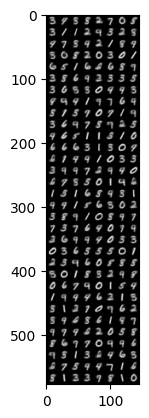

Epoch [30/30], Step [235/234], Total loss : 57.052008 Recon Loss: 52.825317, KLD Loss: 4.226691: 100%|██████████| 234/234 [00:04<00:00, 48.68it/s]


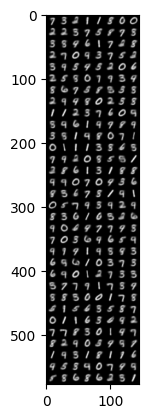

Saving gif file...


In [35]:

config.beta = 1
config.epoch = 30
train_loader = MNISTdataloader(train=True, batch_size=config.batch_size)
test_loader = MNISTdataloader(train=False, batch_size=config.batch_size)
encoder = Encoder(hidden_dims = config.hidden_dims, latent_dim=config.latent_dim,model_name='VAE').to(device)
decoder = Decoder(hidden_dims = config.hidden_dims, latent_dim=config.latent_dim,expand_dim=config.expand_dim).to(device)
encoder.apply(initialize_weights)
decoder.apply(initialize_weights)
trainer = train_VAE(train_loader, test_loader,encoder, decoder, device, config, \
                       save_img=True,model_name='VAE',beta=config.beta,img_show=True)
results_VAE = trainer.train()

In [36]:
trained_encoder_VAE = results_VAE['encoder']
trained_decoder_VAE = results_VAE['decoder']
recon_loss_VAE= results_VAE['Recon_loss_history']
KLD_loss_VAE= results_VAE['KLD_loss_history']

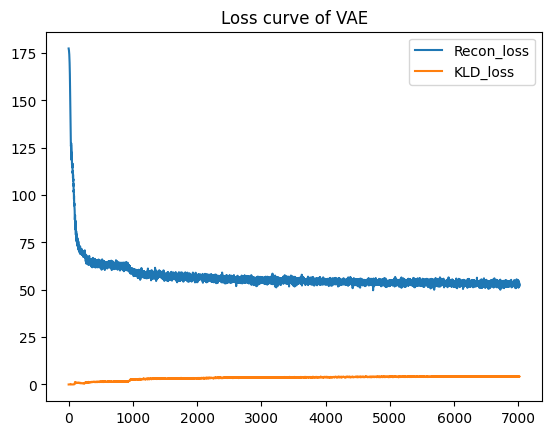

In [59]:
plt.title("Loss curve of VAE")
plt.plot(recon_loss_VAE, label='Recon_loss')
plt.plot(KLD_loss_VAE, label='KLD_loss')
plt.legend()
plt.savefig(save_path+"VAE_loss.png")
plt.show()

### Let's train beta-VAE!


Epoch [1/30], Step [235/234], Total loss : 68.838074 Recon Loss: 68.804749, KLD Loss: 0.033325: 100%|██████████| 234/234 [00:05<00:00, 46.25it/s]


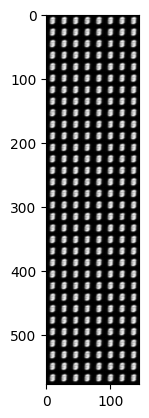

Epoch [2/30], Step [235/234], Total loss : 64.952840 Recon Loss: 63.997898, KLD Loss: 0.954942: 100%|██████████| 234/234 [00:04<00:00, 48.30it/s]


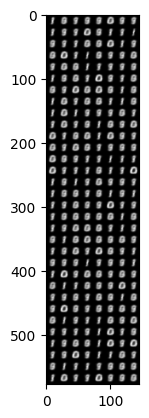

Epoch [3/30], Step [235/234], Total loss : 65.375588 Recon Loss: 64.364616, KLD Loss: 1.010972: 100%|██████████| 234/234 [00:04<00:00, 48.92it/s]


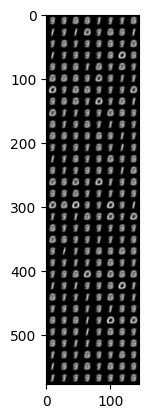

Epoch [4/30], Step [235/234], Total loss : 63.272037 Recon Loss: 62.240955, KLD Loss: 1.031081: 100%|██████████| 234/234 [00:04<00:00, 48.31it/s]


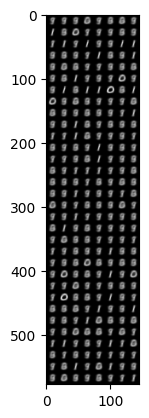

Epoch [5/30], Step [235/234], Total loss : 64.306385 Recon Loss: 63.039330, KLD Loss: 1.267056: 100%|██████████| 234/234 [00:04<00:00, 50.39it/s]


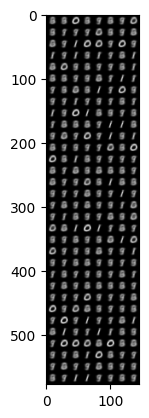

Epoch [6/30], Step [235/234], Total loss : 64.338672 Recon Loss: 63.115314, KLD Loss: 1.223357: 100%|██████████| 234/234 [00:04<00:00, 49.97it/s]


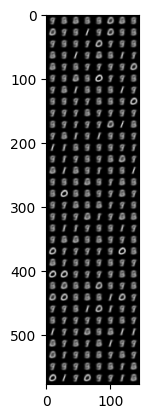

Epoch [7/30], Step [235/234], Total loss : 64.044203 Recon Loss: 62.764919, KLD Loss: 1.279284: 100%|██████████| 234/234 [00:04<00:00, 50.17it/s]


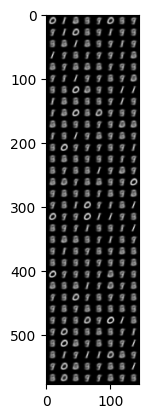

Epoch [8/30], Step [235/234], Total loss : 65.054956 Recon Loss: 63.715675, KLD Loss: 1.339281: 100%|██████████| 234/234 [00:04<00:00, 50.11it/s]


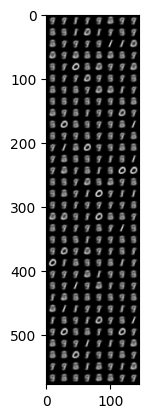

Epoch [9/30], Step [235/234], Total loss : 61.552611 Recon Loss: 59.425606, KLD Loss: 2.127006: 100%|██████████| 234/234 [00:04<00:00, 49.94it/s]


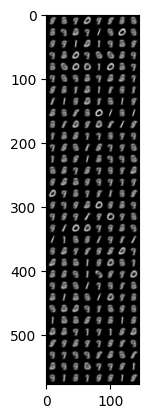

Epoch [10/30], Step [235/234], Total loss : 61.597684 Recon Loss: 59.344444, KLD Loss: 2.253240: 100%|██████████| 234/234 [00:04<00:00, 49.81it/s]


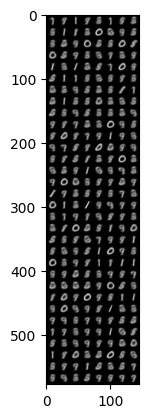

Epoch [11/30], Step [235/234], Total loss : 61.286752 Recon Loss: 59.053112, KLD Loss: 2.233640: 100%|██████████| 234/234 [00:04<00:00, 50.04it/s]


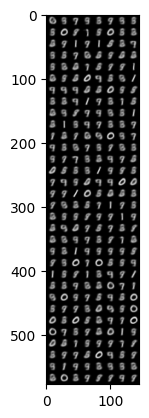

Epoch [12/30], Step [235/234], Total loss : 62.186682 Recon Loss: 59.832870, KLD Loss: 2.353812: 100%|██████████| 234/234 [00:04<00:00, 49.36it/s]


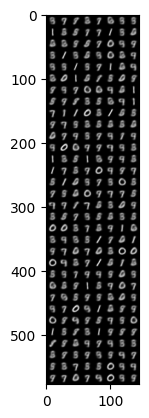

Epoch [13/30], Step [235/234], Total loss : 59.031263 Recon Loss: 56.592010, KLD Loss: 2.439253: 100%|██████████| 234/234 [00:04<00:00, 49.67it/s]


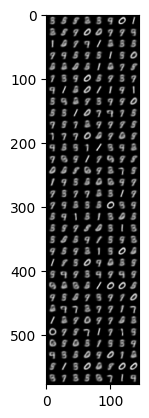

Epoch [14/30], Step [235/234], Total loss : 60.334161 Recon Loss: 57.678959, KLD Loss: 2.655202: 100%|██████████| 234/234 [00:04<00:00, 49.41it/s]


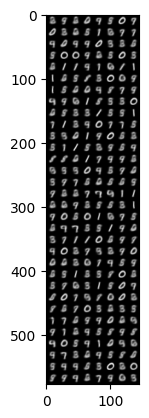

Epoch [15/30], Step [235/234], Total loss : 59.345926 Recon Loss: 56.891148, KLD Loss: 2.454779: 100%|██████████| 234/234 [00:04<00:00, 49.57it/s]


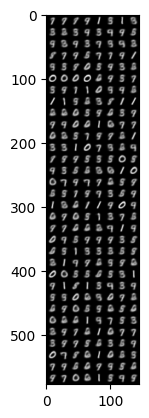

Epoch [16/30], Step [235/234], Total loss : 58.805860 Recon Loss: 56.111412, KLD Loss: 2.694448: 100%|██████████| 234/234 [00:04<00:00, 49.81it/s]


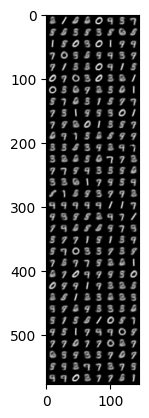

Epoch [17/30], Step [235/234], Total loss : 58.886909 Recon Loss: 56.063828, KLD Loss: 2.823081: 100%|██████████| 234/234 [00:04<00:00, 49.65it/s]


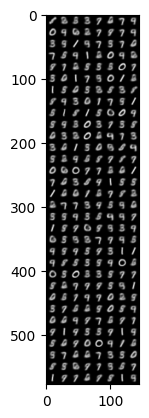

Epoch [18/30], Step [235/234], Total loss : 59.362995 Recon Loss: 56.545074, KLD Loss: 2.817921: 100%|██████████| 234/234 [00:04<00:00, 50.16it/s]


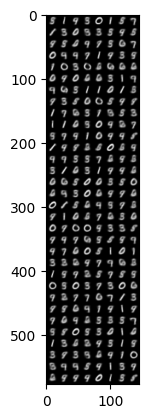

Epoch [19/30], Step [235/234], Total loss : 58.737879 Recon Loss: 56.030811, KLD Loss: 2.707068: 100%|██████████| 234/234 [00:04<00:00, 49.76it/s]


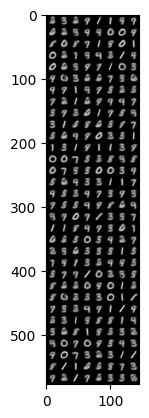

Epoch [20/30], Step [235/234], Total loss : 58.527930 Recon Loss: 55.744270, KLD Loss: 2.783659: 100%|██████████| 234/234 [00:04<00:00, 50.18it/s]


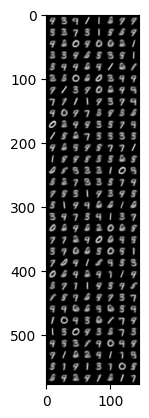

Epoch [21/30], Step [235/234], Total loss : 58.873544 Recon Loss: 55.955757, KLD Loss: 2.917787: 100%|██████████| 234/234 [00:04<00:00, 49.78it/s]


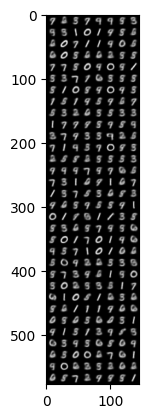

Epoch [22/30], Step [235/234], Total loss : 57.180511 Recon Loss: 54.216938, KLD Loss: 2.963573: 100%|██████████| 234/234 [00:04<00:00, 49.88it/s]


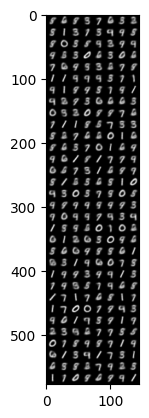

Epoch [23/30], Step [235/234], Total loss : 58.762203 Recon Loss: 55.952290, KLD Loss: 2.809913: 100%|██████████| 234/234 [00:04<00:00, 49.97it/s]


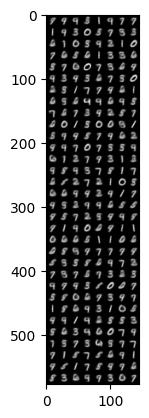

Epoch [24/30], Step [235/234], Total loss : 59.145847 Recon Loss: 56.181297, KLD Loss: 2.964550: 100%|██████████| 234/234 [00:04<00:00, 49.87it/s]


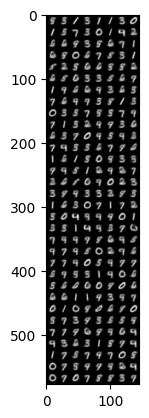

Epoch [25/30], Step [235/234], Total loss : 58.921385 Recon Loss: 55.939682, KLD Loss: 2.981703: 100%|██████████| 234/234 [00:04<00:00, 49.65it/s]


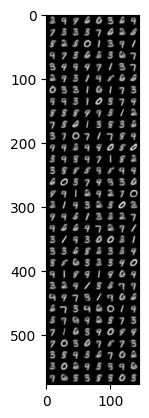

Epoch [26/30], Step [235/234], Total loss : 59.759027 Recon Loss: 56.782475, KLD Loss: 2.976552: 100%|██████████| 234/234 [00:04<00:00, 48.99it/s]


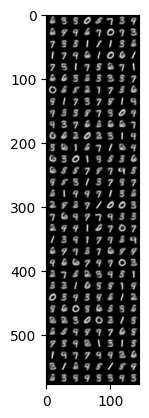

Epoch [27/30], Step [235/234], Total loss : 59.067594 Recon Loss: 56.082748, KLD Loss: 2.984846: 100%|██████████| 234/234 [00:04<00:00, 49.06it/s]


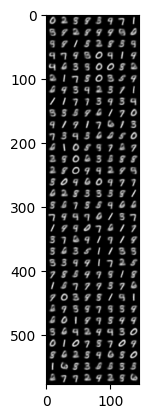

Epoch [28/30], Step [235/234], Total loss : 58.588020 Recon Loss: 55.595051, KLD Loss: 2.992970: 100%|██████████| 234/234 [00:04<00:00, 48.48it/s]


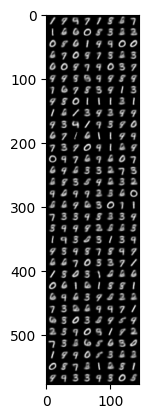

Epoch [29/30], Step [235/234], Total loss : 59.732104 Recon Loss: 56.749069, KLD Loss: 2.983035: 100%|██████████| 234/234 [00:04<00:00, 48.88it/s]


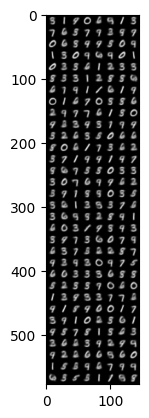

Epoch [30/30], Step [235/234], Total loss : 60.488995 Recon Loss: 57.460793, KLD Loss: 3.028202: 100%|██████████| 234/234 [00:04<00:00, 50.07it/s]


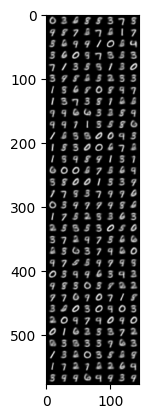

Saving gif file...


In [38]:
from HW4_1_YourAnswer import *
from utils import initialize_weights
config.beta = 2
train_loader = dataloader(train=True, batch_size=config.batch_size)
test_loader = dataloader(train=False, batch_size=config.batch_size)
encoder = Encoder(hidden_dims = config.hidden_dims, latent_dim=config.latent_dim,model_name='VAE').to(device)
decoder = Decoder(hidden_dims = config.hidden_dims, latent_dim=config.latent_dim,expand_dim=config.expand_dim).to(device)
encoder.apply(initialize_weights)
decoder.apply(initialize_weights)
trainer = train_VAE(train_loader, test_loader,encoder, decoder, device, config, \
                       save_img=True,model_name='VAE',beta=config.beta,img_show=True)
results_beta_VAE = trainer.train()

In [39]:
trained_encoder_beta_VAE = results_beta_VAE['encoder']
trained_decoder_beta_VAE = results_beta_VAE['decoder']
recon_loss_beta_VAE= results_beta_VAE['Recon_loss_history']
KLD_loss_beta_VAE= results_beta_VAE['KLD_loss_history']

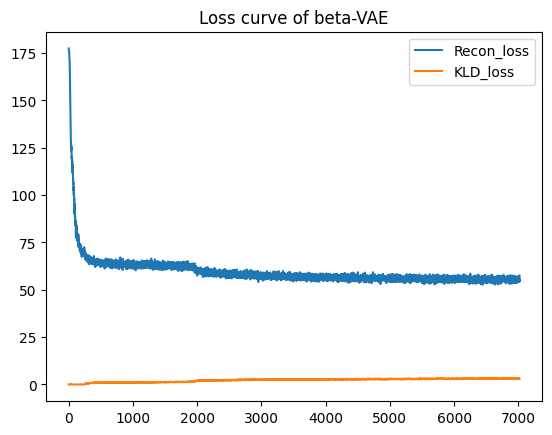

In [60]:
plt.title("Loss curve of beta-VAE")
plt.plot(recon_loss_beta_VAE, label='Recon_loss')
plt.plot(KLD_loss_beta_VAE, label='KLD_loss')
plt.legend()
plt.savefig(save_path+"beta_VAE_loss.png")
plt.show()

## Visualization of the training result
The following results are obtained from the training:
- The generated image of the AE, VAE, and beta-VAE from same images
- The reconstructed image of the AE, VAE, and beta-VAE from same images
- The representation of the output with the change of latent vector
- Visualization of the latent space mapping of the VAE and AutoEncoder
- Visualization of the output image depending on the latent vector

In [41]:

test_loader = MNISTdataloader(train=False, batch_size=64)
num_col=8
for batch_idx, (image, label) in enumerate(test_loader):
    image = (image).to(device)
    param = trained_encoder_AE(image)
    output_AE = trained_decoder_AE(param)
    grid_output_AE = torchvision.utils.make_grid(output_AE, nrow=num_col, normalize=True).cpu().detach().permute(1,2,0).numpy()
    mu, log_var, reparam = trained_encoder_VAE(image)
    output_VAE = trained_decoder_VAE(reparam)
    grid_output_VAE = torchvision.utils.make_grid(output_VAE, nrow=num_col, normalize=True).cpu().detach().permute(1,2,0).numpy()
    mu, log_var, beta_reparam = trained_encoder_beta_VAE(image)
    output_beta_VAE = trained_decoder_beta_VAE(beta_reparam)
    grid_output_beta_VAE = torchvision.utils.make_grid(output_beta_VAE, nrow=num_col, normalize=True).cpu().detach().permute(1,2,0).numpy()
    break

Let's compare the generated images of the AE, VAE, and beta-VAE.

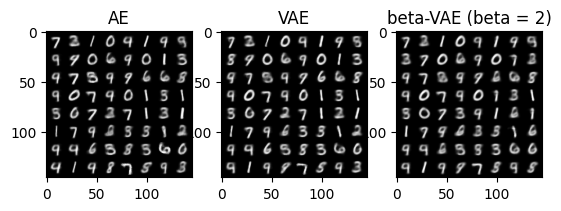

In [61]:
plt.subplot(1,3,1)
plt.title("AE")
plt.imshow(grid_output_AE)
plt.subplot(1,3,2)
plt.title("VAE")
plt.imshow(grid_output_VAE)
plt.subplot(1,3,3)
plt.title(f"beta-VAE (beta = {config.beta})")
plt.imshow(grid_output_beta_VAE)
plt.savefig(save_path+"AE_gen_imgs.png")
plt.show()

### The reconstructed image of the AE, VAE, and beta-VAE from same images
The input image is the leftmost image, and the output image is the 2nd,3rd and 4th image from left. It might fail to reconstruct the input image due to insufficient training, but you can see that the output image is similar to the input image.

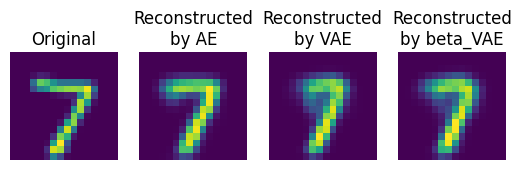

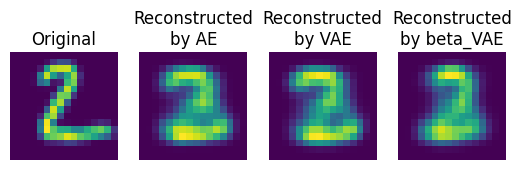

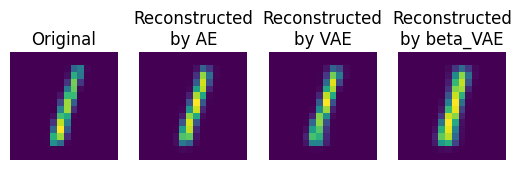

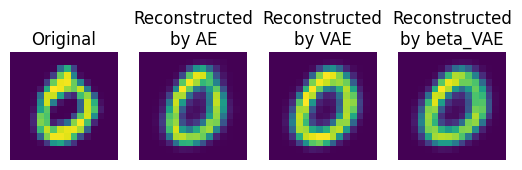

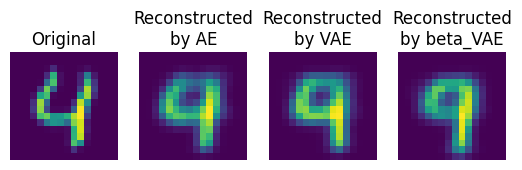

In [62]:
output = {'AE':output_AE.detach().cpu().numpy(),
          'VAE':output_VAE.detach().cpu().numpy(),
          'beta_VAE':output_beta_VAE.detach().cpu().numpy()}
show_image_real_and_VAE(image,output,num_img=5)


### The representation of the output with the change of latent vector
In the following figure, the visualization of the output image depending on the latent vector is depicted. Since the AE does not consider the distribution of the latent vector, the output image sometimes cannot produces image depending on the latent vector. On the other hand, the VAE considers the distribution of the latent vector, so the output image is changed depending on the latent vector. The image will be changed smoothly because the latent vector is sampled from the Gaussian distribution.

The generated image is as follows:

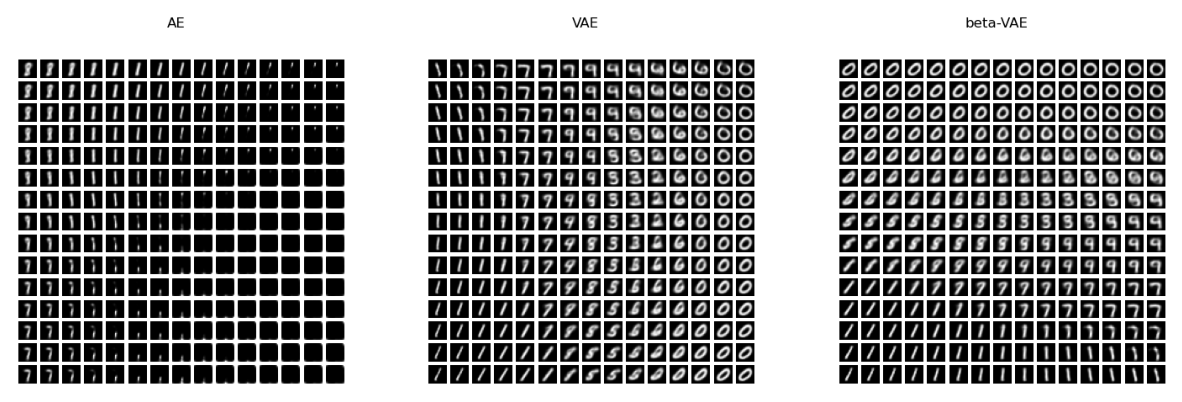

In [63]:
AE_img = cv2.imread("./test_file/AE_latent_vector_img.png")
VAE_img = cv2.imread("./test_file/VAE_latent_vector_img.png")
beta_VAE_img = cv2.imread("./test_file/beta_VAE_latent_vector_img.png")
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.axis("off")
plt.imshow(AE_img)
plt.subplot(1,3,2)
plt.axis("off")
plt.imshow(VAE_img)
plt.subplot(1,3,3)
plt.axis("off")
plt.imshow(beta_VAE_img)
plt.savefig(save_path+"MNIST_gen_images.png")
plt.show()

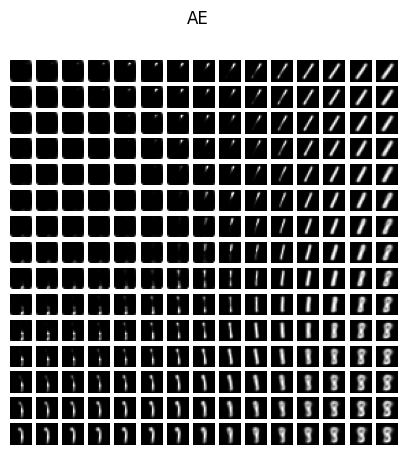

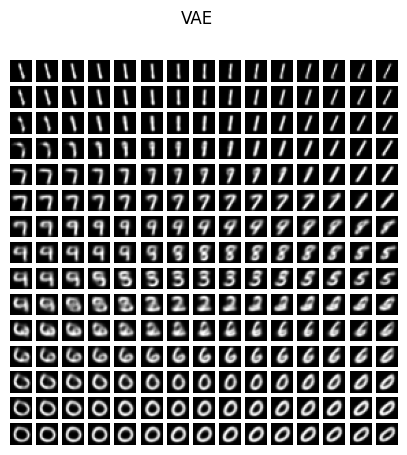

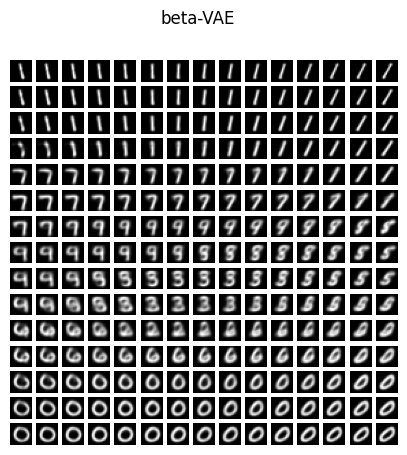

In [64]:
config.latent_dim = 2
show_image_VAE('AE',trained_decoder_AE,config.latent_dim,size=15)
plt.pause(0.01)
show_image_VAE('VAE',trained_decoder_VAE,config.latent_dim,size=15)
plt.pause(0.01)
show_image_VAE('beta-VAE',trained_decoder_beta_VAE,config.latent_dim,size=15)
plt.pause(0.01)

# Visualization of the latent vector of the VAE and AE
The visualization of the latent vector is performed to compare the latent vector of the VAE and AE.

For comparison, we will use the trained AE and VAE with same structure. The latent vector of the VAE is on the left, and the latent vector of the AE is on the right.

The latent vector of the VAE is more evenly distributed and centered among origin point than the latent vector of the AE. This is because the VAE is trained with the KL divergence loss, which makes the latent vector evenly distributed. Therefore, it has benefit to generate more diverse images. It leads to understanding the latent vector of the VAE is more interpretable than the AE latent vector. Due to insufficient training, the latent vector of the AE and VAE might be quite far from the wanted distribution.. However, you can see the difference between the latent vector of the VAE and AE.

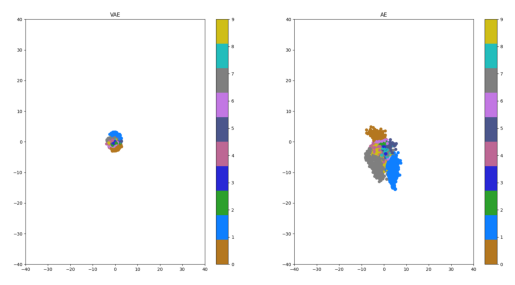

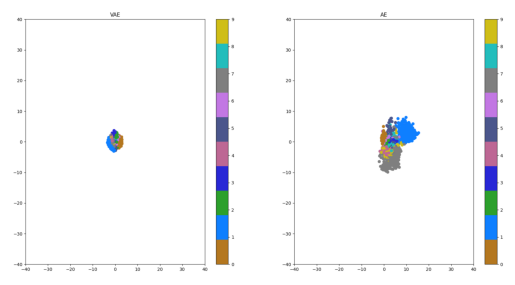

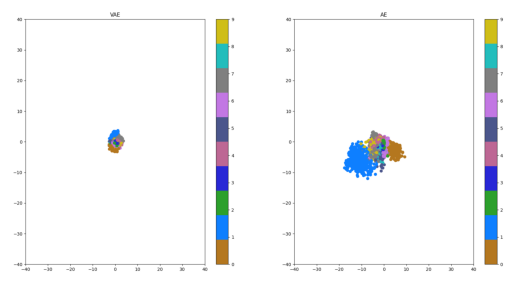

In [65]:
import cv2
import matplotlib.pyplot as plt
output = cv2.imread("./utils/test_file/VAE_AE_output.png")
plt.axis('off')
plt.imshow(output)
plt.pause(0.01)
output = cv2.imread("./utils/test_file/VAE_AE_output_1.png")
plt.axis('off')
plt.imshow(output)
plt.pause(0.01)
output = cv2.imread("./utils/test_file/VAE_AE_output_2.png")
plt.axis('off')
plt.imshow(output)
plt.show()

### Let's compare the latent vector of the VAE and AE!

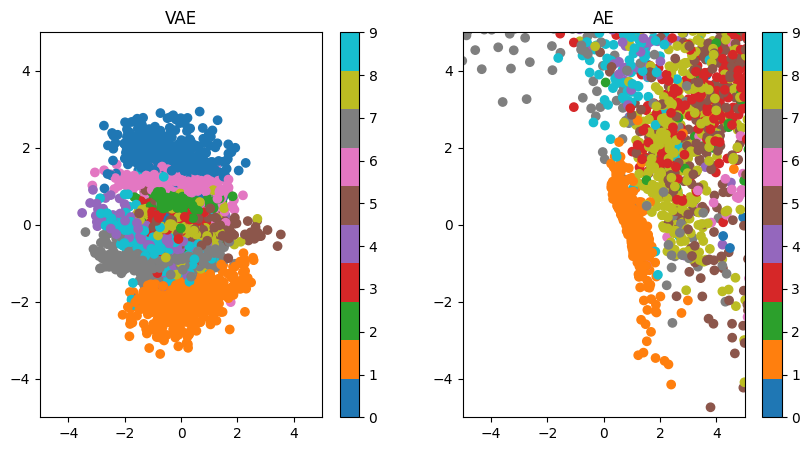

In [66]:
plt.figure(figsize=(10,5))
visualize_latent_dim(trained_encoder_VAE, title='VAE',position='left')
visualize_latent_dim(trained_encoder_AE, title='AE',position='right')

## The generated image of the VAE depending on the latent vector dimension
From now on, the latent vector of the VAE is 2-dimensional. Let's change the dimension of latent vector with 5,10 and see the change of results. Here, the model is trained for 15 epochs since the larger dimension of latent vector needs more training. After training, we can see the generated image of the VAE depending on the latent vector dimension with the same noise, `eps`. It might be a very marginal difference, but the difference between the generated image of the VAE depending on the latent vector dimension can be observed.

In [67]:
from HW4_1_YourAnswer import *
VAEs = []
config.epoch = 30
for latent_dim in [5,10]:
    # train VAE
    config.latent_dim = latent_dim
    train_loader = dataloader(train=True, batch_size=config.batch_size)
    test_loader = dataloader(train=False, batch_size=config.batch_size)
    encoder_high_dim = Encoder(hidden_dims = config.hidden_dims, latent_dim=config.latent_dim,model_name='VAE').to(device)
    decoder_high_dim = Decoder(hidden_dims = config.hidden_dims, latent_dim=config.latent_dim,expand_dim=config.expand_dim).to(device)

    trainer_high_dim = train_VAE(train_loader, test_loader,encoder_high_dim, decoder_high_dim, device, config, \
                           save_img=False,model_name='VAE',beta=1,img_show=False)
    results_high_dim = trainer_high_dim.train()
    trained_encoder_VAE_high_dim = results_high_dim['encoder']
    trained_decoder_VAE_high_dim = results_high_dim['decoder']
    VAEs.append((latent_dim,trained_encoder_VAE_high_dim,trained_decoder_VAE_high_dim))

Epoch [1/30], Step [235/234], Total loss : 63.377984 Recon Loss: 60.617970, KLD Loss: 2.760015: 100%|██████████| 234/234 [00:04<00:00, 47.32it/s]
Epoch [2/30], Step [235/234], Total loss : 58.280061 Recon Loss: 53.180290, KLD Loss: 5.099771: 100%|██████████| 234/234 [00:04<00:00, 49.62it/s]
Epoch [3/30], Step [235/234], Total loss : 55.022734 Recon Loss: 49.154221, KLD Loss: 5.868513: 100%|██████████| 234/234 [00:04<00:00, 49.71it/s]
Epoch [4/30], Step [235/234], Total loss : 54.813316 Recon Loss: 48.861877, KLD Loss: 5.951438: 100%|██████████| 234/234 [00:04<00:00, 49.83it/s]
Epoch [5/30], Step [235/234], Total loss : 55.757507 Recon Loss: 49.631660, KLD Loss: 6.125847: 100%|██████████| 234/234 [00:04<00:00, 49.87it/s]
Epoch [6/30], Step [235/234], Total loss : 55.269051 Recon Loss: 48.902004, KLD Loss: 6.367046: 100%|██████████| 234/234 [00:04<00:00, 49.49it/s]
Epoch [7/30], Step [235/234], Total loss : 54.689744 Recon Loss: 48.305038, KLD Loss: 6.384705: 100%|██████████| 234/234 [00

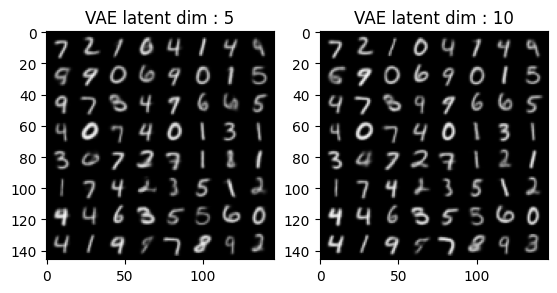

In [68]:
from HW4_1_YourAnswer import dataloader
test_loader = dataloader(train=False, batch_size=64)
for image,label in test_loader:
    image = image.to(device)
    break
plt.figure(figsize=(10, 10))
eps = torch.randn(64, 20).to(device)
for i in range(len(VAEs)):
    latent_dim,trained_encoder_VAE,trained_decoder_VAE = VAEs[i]
    _, _, rp = trained_encoder_VAE(image,eps[:,:latent_dim])
    output = trained_decoder_VAE(rp)
    output = torchvision.utils.make_grid(output.cpu().detach(), nrow=8)
    output = output.numpy().transpose(1,2,0)
    plt.subplot(1,3, i+1)
    plt.title(f"VAE latent dim : {latent_dim}")
    plt.imshow(output)
    plt.savefig(save_path+f"VAE_latent_{str(latent_dim)}.png")

**References**


1.   *PyTorch documentation - PyTorch 2.1 documentation*. Available at: https://pytorch.org/docs/stable/index.html

2. Kingma, D.P. and Welling, M. (2019), *An introduction to variational autoencoders*, arXiv.org. Available at: https://arxiv.org/abs/1906.02691 